## Convolutional Neural Networks

Building a neural network using PyTorch for FashionMnist data for Image classification.

Convolutional Neural Network is the most popular approach to extracting features from an image without too much computation (compared to a fully connected layer).

Import the neccesary packages required to build the model.
Fix a seed through out the process to have a deterministic behaviour (reproduce same results) of the model.

In [1]:
## Imports
import os
import time
import numpy as np
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy.testing as npt
#from torchsummary import summary
# from tqdm import trange

# Checks for the availability of GPU
is_cuda = torch.cuda.is_available()
if torch.cuda.is_available():
    print("working on gpu!")
else:
    print("No gpu! only cpu ;)")


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = '0'


working on gpu!


### Setting up the DataLoaders

Using IFashionMNIST dataset

In [2]:
import torchvision
import torchvision.transforms as transforms
import os

if not os.path.isdir('./data'):
    os.mkdir('./data')
root = './data/'

# List of transformation on the data - normalize the image data to (-1,1)
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5), (0.5)),])
# Geta  handle to Load the data
training_data = torchvision.datasets.FashionMNIST(root, train=True, transform=transform,download=True)
testing_data = torchvision.datasets.FashionMNIST(root, train=False, transform=transform,download=True)

num_train = len(training_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_bs = 60
test_bs = 50

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Create Data loaders, use to extract minibatches of data to input to the network for training
train_loader = torch.utils.data.DataLoader(training_data, batch_size=train_bs,
    sampler=train_sampler, drop_last=False)
valid_loader = torch.utils.data.DataLoader(training_data, batch_size=train_bs,
    sampler=valid_sampler, drop_last=False)
test_loader = torch.utils.data.DataLoader(testing_data, batch_size=test_bs,
    drop_last=False)


100%|██████████| 26421880/26421880 [00:11<00:00, 2336547.71it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 201974.28it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:04<00:00, 1065956.21it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23885262.16it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### Visualize a Few Data Samples

In the following cell use a random batch of images together with labels and visualize them.

torch.Size([50, 1, 28, 28])


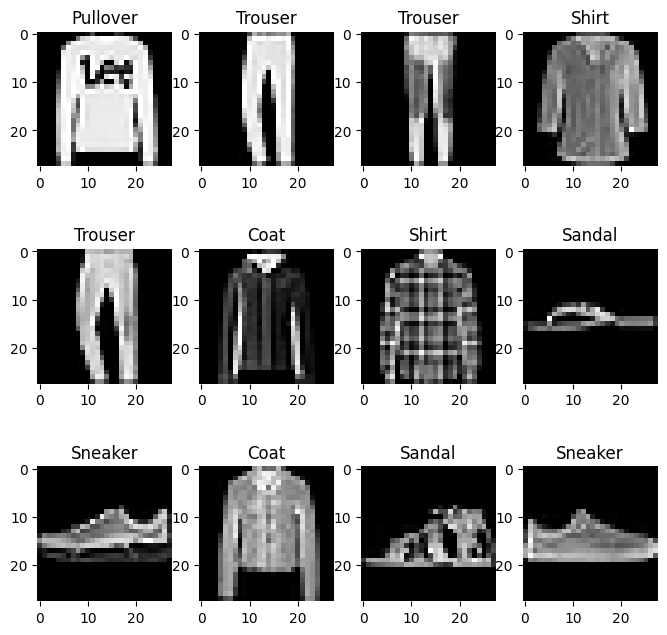

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

test_iter = iter(test_loader)
images, labels = next(test_iter)



image_dict = {0:'T-shirt/Top', 1:'Trouser', 2:'Pullover', 3:'Dress',
              4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker',
              8:'Bag', 9:'Ankle Boot'}

fig = plt.figure(figsize=(8,8))

print(images.size())

for i in np.arange(1, 13):
    ax = fig.add_subplot(3,4,i, frameon=False)
    img = images[i][0]
    ax.set_title(image_dict[labels[i].item()])
    plt.imshow(img, cmap='gray')


### Architecture

I implement a Convolutional Neural Network as our model.
The layers in our model.
- a convolution layer for extracting features.
- batchnorm layer for normalizing the weights.
- ReLU activation function for the non-linearity between layers.
- Finally fully connected layers in the end.

#### Model:

The following convolutional neural network architecture for our dataset.

- convolution layer output_channels-16 kernel_size=3 stride=1 padding-1
- batchnormalization layer
- ReLU activation layer
- maxpool layer kernel_size=2 stride=2
- convolution layer output_channels-32 kernel_size=3 stride=1 padding-1
- batchnormalization layer
- ReLU activation layer
- maxpool layer kernel_size=2 stride=2
- convolution layer output_channels-64 kernel_size=5 stride=1 padding-2
- batchnormalization layer
- ReLU activation layer
- maxpool layer kernel_size=2 stride=2
- fully connected layer - number_of_classes

### Build the model

- Frist define a class called Model nheriting from Pytorch's nn.Module.
- In init(constructor), define all the layers that are used to build the model
- Define a forward function for a sequential model that takes in images as input and returns the predictions as output.


In [5]:
import torch.nn as nn

class Model(nn.Module):
    ## init function is the constructor and we define all the layers used in our model.
    def __init__(self, num_classes=10):
        super(Model, self).__init__()


        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1,padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,stride=1,padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.fc = nn.Linear(576,num_classes)


    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)

        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc(x)

        return x


    def flatten(self,x):
        N, C, H, W = x.size()
        #reshape x to (N, C*H*W)

        # your code here
        x = x.view(N,C*H*W)

        return x




In [6]:
model = Model(num_classes=10)
test_input1 = torch.randn(16,1,28,28)
out1 = model(test_input1)
test_input2 = torch.rand(20,1,28,28)
out2 = model(test_input2)

In [7]:
# Setting up a few learning parameters
learning_rate = 1e-2
decayRate = 0.999
epochs = 5
number_of_classes = 10

### Initialize the CNN Model

Define a loss criterion, use cross-entropy loss between the predictions and ground truth to estimate the loss.


Define a optimization strategy to update the weights. Adam optimizer from the PyTorch package.

In [8]:
## define an instance of the model to train
model = Model(num_classes=number_of_classes)
print(model)

#Move the model to the gpu if is_cuda
if is_cuda:
  model = model.cuda()

# define the loss 'criterion' as nn.CrossEntropyLoss() object

criterion = nn.CrossEntropyLoss()


# Initialize the Adam optimizer for the model.parameters() using the learning_rate

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

# learning rate scheduler
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

# optimizer = None

Model(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=576, out_features=10, bias=True)
)


In [9]:
out = torch.FloatTensor([[0.1,0.8,0.05,0.05]])
true = torch.LongTensor([1])
assert criterion(out, true), 0.8925

### Training the Model

The training loop is setup in the following way:

For every batch in the defined number of epochs

- Move the images and labels to the gpu by checking is_cuda
- Extract output by passing images through the model
- pass the output and ground truth to the loss criterion for batch loss
- clear the gradients
- backpropagate (compute gradients w.r.t the parameters) using backward()
- update the parameters with a single optimization step
- update the training loss for plots

repeat

In [10]:
## training loop

## Number of epochs the model runs

def train_model(epochs=25, validate=True):
    '''
    A function to train the model on the dataset and returns the trained model, training loss and
    validation loss for every epoch.

    Inputs:
        epochs: Number of times the model should be trained on the whole data.
        validate: A boolean parameter that validates on validation data.

    Outputs:
        model: The model trained for specified number of epochs
        training loss: A list of training losses computed for every epoch.
        validation loss: A list of validation losses computed for every epoch.

    '''
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        # Iterate through the batches in the data
        training_loss = 0.0
        validation_loss = 0.0

        model.train()
        itr = 0
        for (images,labels)  in train_loader:
            if is_cuda:
                images=images.cuda()
                labels=labels.cuda()
            outputs=model(images)
            loss = criterion(outputs,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            my_lr_scheduler.step()
            training_loss+=loss.item()



            if itr%100 == 0:
                print('Epoch %d/%d, itr = %d, Train Loss = %.3f, LR = %.3E'\
                      %(epoch, epochs, itr, loss.item(),optimizer.param_groups[0]['lr']))
            itr += 1
        train_loss.append(training_loss/len(train_loader))
        print('------------------------------------------------')


        if validate:
            model.eval()
            with torch.no_grad():
                itr = 0
                for (images,labels)  in valid_loader:
                    if is_cuda:
                        images=images.cuda()
                        labels=labels.cuda()
                    outputs=model(images)
                    loss = criterion(outputs,labels)
                    validation_loss+=loss.item()





                    if itr%100 == 0:
                        print('Epoch %d/%d, itr = %d, Val Loss = %.3f, LR = %.3E'\
                              %(epoch, epochs, itr, loss.item(),optimizer.param_groups[0]['lr']))
                    itr += 1
                val_loss.append(validation_loss/len(valid_loader))
                print('################################################')

    return model, train_loss, val_loss


In [11]:
start = time.time()
trained_model, train_loss, val_loss = train_model(epochs, validate=True)
end = time.time()
print('Time to train in seconds ',(end - start))

Epoch 0/5, itr = 0, Train Loss = 2.381, LR = 9.990E-03
Epoch 0/5, itr = 100, Train Loss = 0.478, LR = 9.039E-03
Epoch 0/5, itr = 200, Train Loss = 0.540, LR = 8.178E-03
Epoch 0/5, itr = 300, Train Loss = 0.470, LR = 7.400E-03
Epoch 0/5, itr = 400, Train Loss = 0.367, LR = 6.695E-03
Epoch 0/5, itr = 500, Train Loss = 0.409, LR = 6.058E-03
Epoch 0/5, itr = 600, Train Loss = 0.217, LR = 5.481E-03
Epoch 0/5, itr = 700, Train Loss = 0.276, LR = 4.959E-03
------------------------------------------------
Epoch 0/5, itr = 0, Val Loss = 0.306, LR = 4.491E-03
Epoch 0/5, itr = 100, Val Loss = 0.213, LR = 4.491E-03
################################################
Epoch 1/5, itr = 0, Train Loss = 0.250, LR = 4.487E-03
Epoch 1/5, itr = 100, Train Loss = 0.260, LR = 4.060E-03
Epoch 1/5, itr = 200, Train Loss = 0.222, LR = 3.673E-03
Epoch 1/5, itr = 300, Train Loss = 0.295, LR = 3.324E-03
Epoch 1/5, itr = 400, Train Loss = 0.161, LR = 3.007E-03
Epoch 1/5, itr = 500, Train Loss = 0.263, LR = 2.721E-03


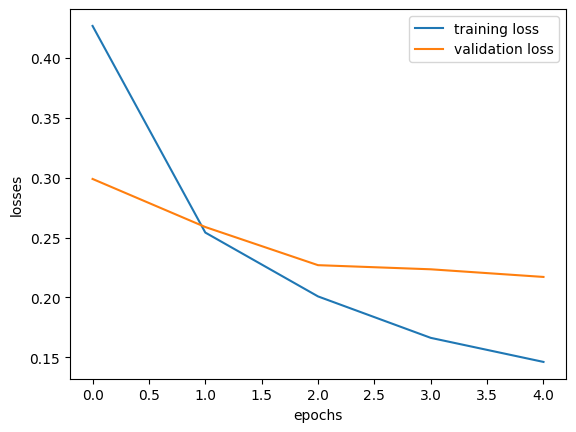

In [13]:
# Plot the losses
it = np.arange(epochs)
plt.plot(it, train_loss, label='training loss')
plt.plot(it, val_loss, label='validation loss')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.legend(loc='upper right')
plt.show()

### Testing the Classsification (30 points)

In the testing loop we don't update the weights. The trained model is tested for all the samples in test data to compute the accuracy and observe how well the model is generalizing to the unseen data.

The testing loop is setup in the following way:

For every batch in the testing data

- Put the model in the evaluation mode and turn off the gradients
- Move the images and labels to the device available
- extract output from the model for the input
- compute the prediction class by choosing the one with maximum probability in the predictions.
- Compare the prediction classes with true classes.
- calculate accuracy
- update test_loss for plots

repeat


In [14]:

def evaluate_model(model, loader):
    '''
    A function to test the trained model on the dataset and print the accuracy on the testset.

    Inputs:
        model: Trained model
        loader: train_loader or test_loader

    outputs:
        accuracy. returns the accuracy of prediction
    '''
    model.eval()
    with torch.no_grad():
        correct = 0
        total_samples = 0
        for images, labels in loader:

            if is_cuda:
                images=images.cuda()
                labels=labels.cuda()

            outputs=model(images)
            predictions = torch.argmax(outputs, dim=1)

            c_matrix = torch.where(predictions == labels, torch.tensor([1.]).to("cuda"),torch.tensor([0.]).to("cuda"))
            correct+=torch.sum(c_matrix)



            total_samples += labels.size(0)

        accuracy = correct/total_samples*100
        print("Total Accuracy on the Input set: {} %".format(accuracy))
        return accuracy

In [23]:
tr_acc = evaluate_model(model, train_loader)
ts_acc = evaluate_model(model, test_loader)
print('Train Accuracy = %.3f'%(tr_acc))
print('Test Accuracy = %.3f'%(ts_acc))

Total Accuracy on the Input set: 95.49166870117188 %
Total Accuracy on the Input set: 91.74999237060547 %
Train Accuracy = 95.492
Test Accuracy = 91.750


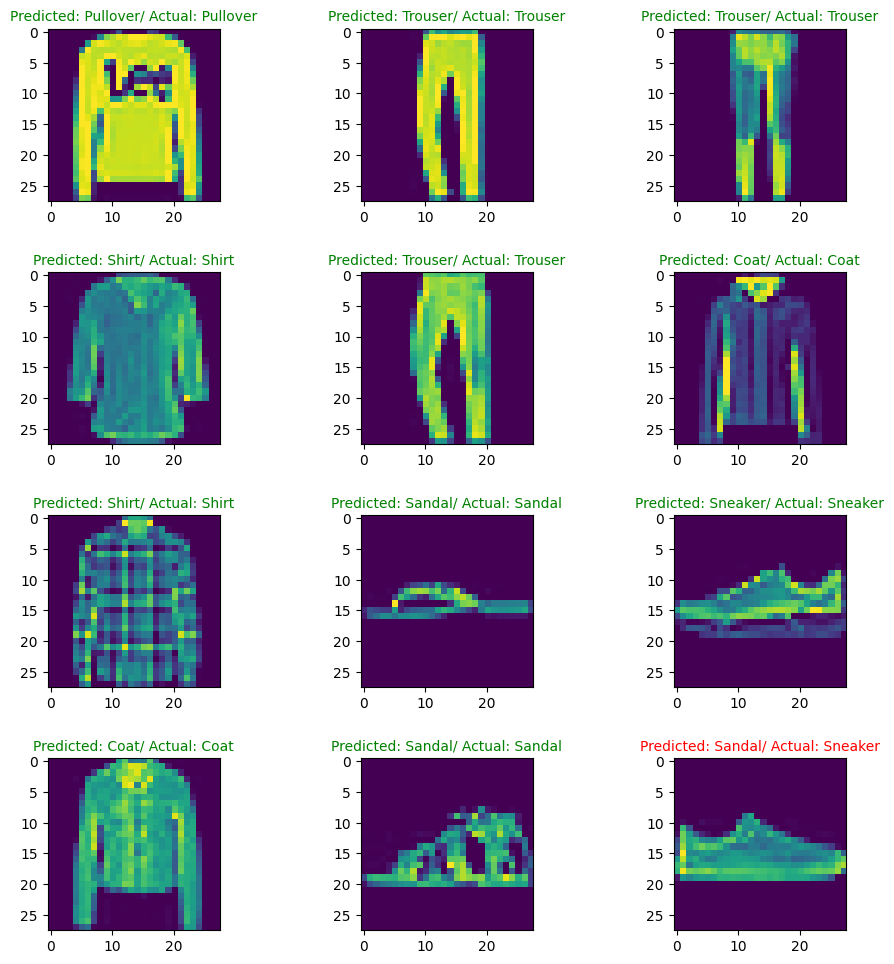

In [27]:
# Visualize the test samples with predicted output and true output
test_iter = iter(test_loader)
images, labels = next(test_iter)

# If CUDA is available, move the images to the GPU
if is_cuda:
    images = images.cuda()
    labels = labels.cuda()

out = model(images)
_, preds = torch.max(out, dim=1)

images = images.to('cpu').numpy()

fig = plt.figure(figsize=(10,10))
for i in np.arange(1, 13):
    ax = fig.add_subplot(4, 3, i)
    plt.imshow(images[i][0])
    ax.set_title("Predicted: {}/ Actual: {}".format(image_dict[preds[i].item()], image_dict[labels[i].item()]),
                color=('green' if preds[i] == labels[i] else 'red'),fontsize=10)
plt.tight_layout(pad=2.0)  # Adjust the padding
plt.show()